In [1]:
import qiskit
import qiskit_ibm_runtime
print(f"Qiskit version: {qiskit.__version__}")
print(f"Runtime version: {qiskit_ibm_runtime.__version__}")

Qiskit version: 2.1.1
Runtime version: 0.41.0


## 7교시 : Qiskit Runtime Advanced Techniques

이전까지 Sampler나 Estimator를 사용할 때에 `Sampler(mode=backend)`와 같이 백엔드를 지정하여 회로를 바로 보내는 방식은 잡(Job) 모드에 해당합니다. 그렇다면 Qiskit Runtime을 사용하는 다른 모드들에 대해서도 알아봐야겠죠?

### 7-1 : 세션(Session) 모드

세션 모드는 여러 번의 양자 컴퓨팅 작업을 연속적으로 수행할 때에 사용할 수 있는 모드입니다. 특히, 최적화 알고리즘과 같이 양자 컴퓨팅 계산을 수행하고 그 결과를 가지고 고전적인 컴퓨팅 작업을 수행한 후, 새로운 회로를 만들어 양자 컴퓨터로 보내는 작업을 반복하는 경우에 유용합니다.

<img src="img/session.svg" width="600"/>

세션이 실행되는 동안은 접속한 양자 컴퓨터를 독점적으로 사용하게 되며, 여러 개의 job을 대기 시간 없이 빠르게 실행할 수 있습니다. 대신, 실제로 양자 회로를 실행하는 시간 뿐만 아니라 고전적인 계산이 수행되는 시간도 사용 시간에 합산되므로 양자 컴퓨터의 사용 시간이 제한적인 경우 사용에 주의가 필요합니다.

아래의 두 예시는 세션을 열어 사용하는 두 가지 방법을 보여줍니다.

In [2]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session, Sampler, Estimator

backend = AerSimulator()
session = Session(backend=backend)
estimator = Estimator(mode=session)
sampler = Sampler(mode=session)
session.close() # Session을 닫는 것을 잊지 마세요!

In [3]:
with Session(backend=backend): # With문을 쓰면 구문이 끝날 때에 자동으로 세션이 닫힙니다.
    estimator = Estimator() # With문으로 열려 있는 세션을 자동으로 가져옵니다.
    sampler = Sampler()

세션을 이용하여 최적화를 수행하는 예시를 살펴봅시다. 이 예시에서는 Qiskit Optimization 패키지를 활용해 최적화 문제를 정의해보겠습니다. 아래의 셀을 실행해 패키지를 설치합니다.

In [ ]:
%pip install qiskit-optimization

아래의 코드를 따라 최적화 문제를 정의하여 관측가능량으로 변환해봅시다.

In [4]:
# Docplex로 최적화 문제를 정의합니다.
from docplex.mp.model import Model

mdl = Model("docplex model")
x = mdl.binary_var("x")
y = mdl.integer_var(lb=-1, ub=5, name="y")
mdl.minimize(-x*y -3*x +y)
mdl.add_constraint(x + y == 0)
print(mdl.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: - 3 x + y + [ - 2 x*y ]/2
Subject To
 c1: x + y = 0

Bounds
 0 <= x <= 1
 -1 <= y <= 5

Binaries
 x

Generals
 y
End



In [5]:
# Docplex 모델을 Qiskit Optimization 라이브러리의 QuadraticProgram 클래스로 가져옵니다.
from qiskit_optimization.translators import from_docplex_mp

mod = from_docplex_mp(mdl)
print(type(mod))
print()
print(mod.prettyprint())

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>

Problem name: docplex model

Minimize
  -x*y - 3*x + y

Subject to
  Linear constraints (1)
    x + y == 0  'c0'

  Integer variables (1)
    -1 <= y <= 5

  Binary variables (1)
    x



In [6]:
# QuadraticProgramToQubo 컨버터와 to_ising 함수를 이용해 문제를 관측가능량으로 변환합니다.
from qiskit_optimization.converters import QuadraticProgramToQubo

conv = QuadraticProgramToQubo()
qubo = conv.convert(mod)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 149.5
Ising Hamiltonian:
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[ -35.  +0.j,  -37.75+0.j,  -75.5 +0.j, -113.25+0.j,    7.25+0.j,
   14.5 +0.j,   21.75+0.j,   15.  +0.j,   22.5 +0.j,   45.  +0.j])


위와 같이 최적화 문제를 관측가능량으로 정의할 수 있습니다. 이제 circuit library의 QAOA 회로를 가져와 scipy 최적화 함수로 최적화를 수행해봅시다. 세션을 활용하여 계산이 연속적으로 수행될 수 있도록 합니다.

In [7]:
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit.library import QAOAAnsatz
from qiskit import generate_preset_pass_manager
from qiskit_aer import AerSimulator

ansatz = QAOAAnsatz(qubitOp, reps=3)
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_ansatz = pm.run(ansatz)
isa_observable = qubitOp.apply_layout(isa_ansatz.layout)  # 관측가능량도 트랜스파일 하는 것을 잊지 마세요!

rng = np.random.default_rng(seed=42)
x0 = 2 * np.pi * rng.random(ansatz.num_parameters)

cost_func_vals = []

def cost_func(params, ansatz, observable, estimator):
    cost = (
        estimator.run([(ansatz, observable, params)])
        .result()[0].data.evs
    )
    cost_func_vals.append(cost)
    return cost

with Session(backend=backend, max_time='1m'):
    options = {"simulator": {"seed_simulator": 42}}
    estimator = Estimator(options=options)
    sampler = Sampler(options=options)
    res = minimize(cost_func, x0, args=(isa_ansatz, isa_observable, estimator), method="cobyla")
    job = sampler.run([(isa_ansatz.measure_active(inplace=False), res.x)])
    counts = job.result()[0].data.meas.get_counts()

print(res)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -109.132568359375
       x: [ 5.863e+00  2.760e+00  5.395e+00  4.386e+00  1.594e+00
            6.128e+00]
    nfev: 61
   maxcv: 0.0


저장한 최적화 곡선을 확인해봅시다.

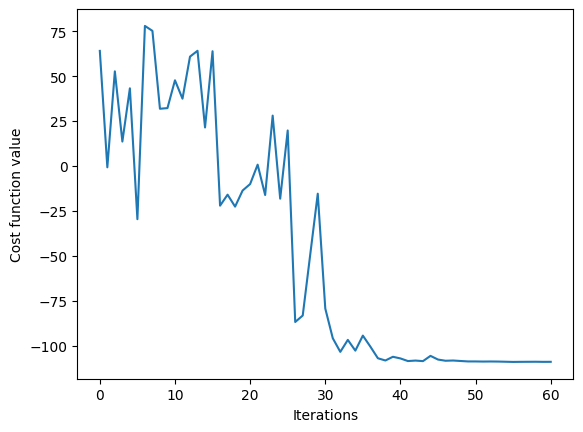

In [8]:
import matplotlib.pyplot as plt

plt.plot(cost_func_vals)
plt.xlabel('Iterations')
plt.ylabel('Cost function value')
plt.show()

최적화가 완료된 상태에서 결과의 분포를 확인합니다.

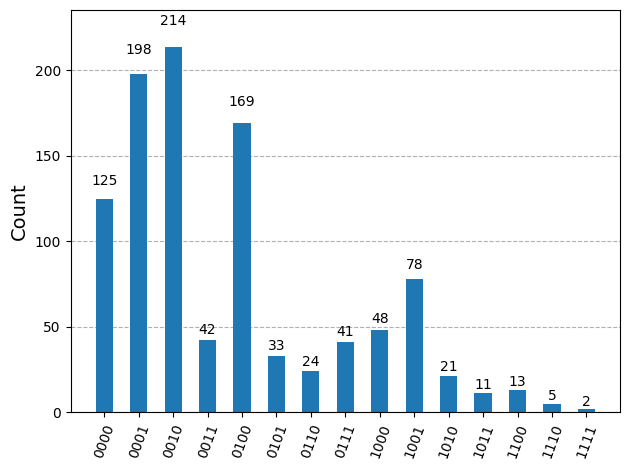

In [9]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

문제의 exact solution도 확인해봅시다.

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(qubitOp)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -152.5
The number of solutions of the problem is 1
The list of the solutions based on their index is [1]


`0001` 이라는 결과가 최적의 값이라는 것을 확인할 수 있습니다. 이 값을 원래의 변수 x, y 값으로 변환하면 어떻게 될까요?

In [11]:
# 컨버터의 interpret 함수로 처음 정의한 x, y 값으로 변환합니다.
# Little endian 정렬에 주의하세요!
print(f'[x, y] = {conv.interpret([1, 0, 0, 0])}')
print(f'Cost function value: {ground_energy + offset}')  # Ising model로 변환할 때 발생한 상수항을 더해줍니다.

[x, y] = [ 1. -1.]
Cost function value: -3.0


x = 1, y = -1 의 값을 가질 때에 함수가 최솟값을 갖는다는 결과를 얻었습니다. 다른 문제에 대해서는 알고리즘이 얼마나 잘 작동하는지도 테스트해보세요!

다음으로 넘어가기 전에 Session의 정보를 표시하는 `details()` 메소드까지 확인을 해보도록 합시다. 세션의 정보는 실제 Qiskit 런타임 서비스를 이용하는 경우에만 표시가 됩니다.

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name='qgss-2025')
backend = service.least_busy()
with Session(backend=backend) as session:
    session.details()

IBMInputValueError: 'No API client found for given instance: crn:v1:bluemix:public:quantum-computing:us-east:a/01f45c7c4c944a6cb2d1a70d952bf851:1fca49e0-4496-4936-ac0b-120fdb0c89bf::'

### 7-2 : 배치(Batch) 모드

배치 모드도 세션 모드와 유사하게 여러 개의 job을 실행할 때에 사용할 수 있습니다. 배치 모드는 특히 여러 개의 복잡한 회로를 실행하는 경우나, cpu/gpu 클러스터를 활용해 병렬적으로 회로를 구성하고 job을 보내는 경우에 유용합니다.

<img src="img/batch.svg" width="600"/>

배치 모드에서는 양자 회로 실행 전후의 전처리/후처리도 병렬적으로 수행되므로, 여러 개의 큐빗을 사용하는 복잡한 양자 회로를 수십/수백 개 이상 실행하는 경우에는 하나의 job으로 회로를 묶어서 보내는 것보다 배치 모드로 서버에서 전처리/후처리 연산이 병렬적으로 수행될 수 있도록 하는 것이 더 빠르게 수행될 수 있습니다.

배치 모드는 양자 컴퓨터의 독점 사용권을 보장하지는 않으며, 배치 실행 중 회로를 실행하지 않는 시간에는 다른 사용자가 양자 컴퓨터를 사용할 수 있습니다. 대신, 배치 모드에서는 실제로 양자 회로를 실행하는 시간만이 사용 시간으로 계산되므로 세션 모드보다 경제적으로 양자 컴퓨터를 사용할 수 있습니다.

배치 모드의 사용법은 세션 모드와 아주 비슷합니다.

In [13]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Batch, Sampler, Estimator

backend = AerSimulator()
batch = Batch(backend=backend)
estimator = Estimator(mode=batch)
sampler = Sampler(mode=batch)
batch.close() # Batch 닫는 것을 잊지 마세요!

In [14]:
with Batch(backend=backend): # With문을 쓰면 구문이 끝날 때에 자동으로 배치가 닫힙니다.
    estimator = Estimator() # With문으로 열려 있는 배치를 자동으로 가져옵니다.
    sampler = Sampler()

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name='qgss-2025')
backend = service.least_busy()
with Batch(backend=backend) as batch:
    batch.details()

IBMInputValueError: 'No API client found for given instance: crn:v1:bluemix:public:quantum-computing:us-east:a/01f45c7c4c944a6cb2d1a70d952bf851:1fca49e0-4496-4936-ac0b-120fdb0c89bf::'

Batch를 활용해 여러 개의 job을 병렬적으로 보내고 실행할 수 있습니다.

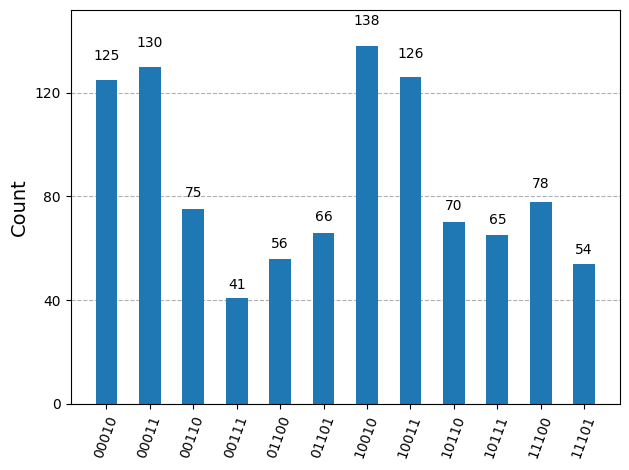

In [16]:
from qiskit import generate_preset_pass_manager
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import Batch
from qiskit_aer import AerSimulator

batch_num = 5
circuit_per_batch = 10

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)

jobs = []

with Batch(backend=backend):
    sampler = Sampler()
    for i in range(batch_num):
        circuits = [random_circuit(5, 5, measure=True, seed=circuit_per_batch*i+j) for j in range(circuit_per_batch)]
        job = sampler.run(pm.run(circuits))
        jobs.append(job)

plot_histogram(jobs[4].result()[8].data.c.get_counts())